
## Discrete Exterior Calculus (DEC) in TopoNetX: what it is, why it exists, and how to think about it

Exterior calculus is the language of geometry for **fields and flows**. It was designed to express things like “take a gradient,” “measure circulation,” or “compute flux through a surface” in a way that is **coordinate-free** and respects the **topology** and **geometry** of the domain.

Discrete Exterior Calculus (DEC) says: we can do the same calculus on a **mesh** (more generally, on a simplicial complex) by replacing smooth differential forms with **cochains** and smooth operators with **sparse linear maps** that preserve the key identities of the continuous theory.

If you care about **PDEs on meshes**, **conservation laws**, **geometry-aware learning**, or **higher-order network structure**, DEC is one of the cleanest “physics-first” ways to build the right linear algebra.

---

### The continuous picture

Let $M$ be an oriented $n$-dimensional Riemannian manifold with metric $g$.

A $k$-form $\alpha \in \Omega^k(M)$ is best understood by what it **does**: it takes an oriented $k$-dimensional piece of space and returns a number interpreted as an **integral**.

* $k=0$: scalar field $f$ (temperature, potential). “Integrate over a point” is just evaluation.
* $k=1$: integrate along an oriented curve (work, circulation).
* $k=2$: integrate over an oriented surface (flux).
* $k=3$: integrate over an oriented volume (mass/charge density).

So the degree $k$ tells you **what geometric carrier** the quantity naturally lives on. That is the DEC mindset: do not force everything to live at vertices; put quantities on vertices/edges/faces/volumes according to meaning.

The two central operators are:

1. Exterior derivative (topology-like):
   $$d:\Omega^k(M)\to\Omega^{k+1}(M),\qquad d^2=0.$$

2. Hodge star (geometry-like):
   $$\star:\Omega^k(M)\to\Omega^{n-k}(M).$$

The star is where geometry enters. It encodes inner products by:
$$\alpha\wedge\star\beta=\langle \alpha,\beta\rangle_g,\mathrm{vol}_g.$$

So: **topology gives you $d$**, geometry (metric + volumes) gives you **$\star$**.

---

### What DEC discretizes

#### Domain: a simplicial complex (a higher-order network with geometry)

Let $K$ be a simplicial complex: vertices, edges, triangles, tetrahedra, and so on. It captures the **combinatorics** of your domain (who is incident to whom). When you also attach vertex positions, you supply the **embedding geometry**.

For each degree $k$, the set of oriented $k$-simplices is $K_k$.

#### Fields: cochains (discrete forms as integrated quantities)

A discrete $k$-form is a **cochain**:
$$C^k(K)={c:K_k\to\mathbb{R}}.$$

Interpretation: for a simplex $\sigma^k\in K_k$,
$$c(\sigma^k)\approx\int_{\sigma^k}\alpha,$$
where $\alpha\in\Omega^k(M)$ is the underlying smooth form.

Domains/codomains (keep these explicit):

* Smooth: $\alpha\in\Omega^k(M)$
* Discrete: $c\in C^k(K)$
* Evaluation: $c(\sigma^k)\in\mathbb{R}$ for $\sigma^k\in K_k$

Concrete meaning by degree:

* $C^0(K)$: values on vertices (potentials, temperature samples)
* $C^1(K)$: integrals along edges (voltage drops, line integrals)
* $C^2(K)$: flux through faces
* $C^3(K)$: integrated densities in volumes

This “already-integrated” viewpoint is exactly why DEC naturally respects conservation and Stokes.

---

### Topology in DEC: the discrete exterior derivative $d_k$

Discrete exterior derivative is the **coboundary**:
$$d_k:C^k(K)\to C^{k+1}(K).$$

Intuition (degree by degree):

* If $f\in C^0$ is a vertex potential, then $d_0 f\in C^1$ gives oriented edge differences (gradient-like).
* If $c\in C^1$ is an edge-circulation cochain, then $d_1 c\in C^2$ measures net circulation around each face (curl-like).
* If $b\in C^2$ is a face-flux cochain, then $d_2 b\in C^3$ measures net flux out of each volume (divergence-like).

Implementation: $d_k$ is determined purely by **incidence + orientation** (boundary relations). In matrix form, it is sparse and metric-free.

The central identity is preserved *exactly*:
$$d_{k+1}d_k=0.$$

This is the algebraic expression of “boundary of a boundary is zero,” and it is what makes DEC structure-preserving.


In [ ]:

import numpy as np
import toponetx as tnx

# One oriented triangle (0,1,2)
sc = tnx.SimplicialComplex([[0, 1, 2]])

# 0-cochain f in C^0(K): values at vertices
f = {0: 1.0, 1: 2.5, 2: -1.0}

# Define d0 f on an oriented edge (u -> v)
# This is the DEC meaning: (d0 f)(edge) = integral of df along the edge
def d0_on_edge(u, v):
    return f[v] - f[u]

# The oriented boundary of face (0,1,2) can be taken as the cycle:
# (0->1) + (1->2) + (2->0)
boundary_edges = [(0, 1), (1, 2), (2, 0)]

# This sum is exactly (d1(d0 f))(0,1,2): the discrete curl of the discrete gradient
vals = np.array([d0_on_edge(u, v) for (u, v) in boundary_edges], dtype=float)
d1_d0_on_face = vals.sum()

print("Values of (d0 f) on boundary edges:", vals)
print("Face value (d1(d0 f))(0,1,2):", d1_d0_on_face)
print("Observe the answer is 0 (this is d1 d0 = 0, i.e., d^2 = 0).")




Values of (d0 f) on boundary edges: [ 1.5 -3.5  2. ]
Face value (d1(d0 f))(0,1,2): 0.0
Should be 0 (this is d1 d0 = 0, i.e., d^2 = 0).


We explain the above example in more details now.

## Why the computations above is really 0, in other words why “$d^2=0$?”

In DEC:

* $d_0:C^0(K)\to C^1(K)$ maps vertex data to oriented edge integrals.
* $d_1:C^1(K)\to C^2(K)$ maps edge data to oriented face integrals.

The identity
$$
d_1 d_0 = 0
$$
means: **if you take a discrete gradient ($d_0 f$), then the discrete curl around every face is zero ($d_1(d_0 f)$).**

The code is computing exactly one entry of $d_1(d_0 f)$: the value on the **single triangle** $(0,1,2)$.

### Step-by-step (on one triangle)

Take a 0-cochain $f\in C^0(K)$:

* $f(0)=1.0$, $f(1)=2.5$, $f(2)=-1.0$.

Compute the 1-cochain $c=d_0 f\in C^1(K)$ on oriented edges:
$$
(d_0 f)(u,v) = f(v)-f(u).
$$

Now apply $d_1$ to this 1-cochain on the oriented face $(0,1,2)$:
$$
(d_1 c)(0,1,2) = c(0,1) + c(1,2) + c(2,0),
$$
where the signs come from the oriented boundary
$$
\partial(0,1,2) = (1,2) - (0,2) + (0,1),
$$
and writing that boundary as the cycle $(0,1),(1,2),(2,0)$ is the same thing.

Plug $c=d_0 f$:
$$
(d_1 d_0 f)(0,1,2)
= (f(1)-f(0)) + (f(2)-f(1)) + (f(0)-f(2)) = 0.
$$

That last line is the “telescoping sum.” It cancels **purely by algebra**, independent of geometry. That’s $d^2=0$.

So the code’s `circulation` is literally the single-face value of $d_1(d_0 f)$.

---


### The identity $d_{k+1}d_k=0$ in the smallest possible example

The defining property of the discrete exterior derivative is:
$$
d_k:C^k(K)\to C^{k+1}(K),
\qquad
d_{k+1}d_k=0.
$$

Interpretation by degree:

* If $f\in C^0(K)$ (a potential on vertices), then $d_0 f\in C^1(K)$ is a discrete “gradient”: it assigns a number to each oriented edge.
* If $c\in C^1(K)$ (edge circulation), then $d_1 c\in C^2(K)$ is a discrete “curl”: it assigns a number to each oriented face (sum around its boundary).
* The identity $d_1 d_0=0$ says: **the discrete gradient has zero circulation around every closed loop** (on each face). This is the discrete analogue of “curl(grad) = 0”.

On a single triangle with boundary cycle $(0\to1)$, $(1\to2)$, $(2\to0)$:
$$
(d_0 f)(u,v)=f(v)-f(u),
$$
and
$$
(d_1(d_0 f))(0,1,2) = (d_0 f)(0,1) + (d_0 f)(1,2) + (d_0 f)(2,0)=0,
$$
because the sum telescopes:
$$
(f(1)-f(0))+(f(2)-f(1))+(f(0)-f(2))=0.
$$





## Main Takeaway:

* This is not a numerical approximation: the zero happens by **cancellation**, so it is exact (up to floating rounding).
* Geometry does not enter here at all. This is purely **topological** (incidence + orientation).
* Geometry enters later through $\star$, when you build energies and Laplacians.


---

### “Discrete Stokes theorem is built in” (what that means, precisely)

#### Continuous Stokes (blueprint)

For a smooth $k$-form $\alpha$ and an oriented $(k+1)$-dimensional region $\tau^{k+1}$:
$$\int_{\tau^{k+1}} d\alpha=\int_{\partial\tau^{k+1}}\alpha.$$

#### Discrete Stokes (exact identity, not approximation)

In DEC, cochains are integrals on simplices. So Stokes becomes a **combinatorial identity** defining $d_k$:

Take $c\in C^k(K)$. For every oriented $\tau^{k+1}\in K_{k+1}$,
$$\langle d_k c,\tau^{k+1}\rangle=\langle c,\partial\tau^{k+1}\rangle.$$

Where:

* $\langle c,\sigma^k\rangle$ is evaluation: $c(\sigma^k)$
* $\partial\tau^{k+1}$ is the signed sum of oriented $k$-faces of $\tau^{k+1}$
* the right-hand side is a signed sum of cochain values on those faces

Why this matters:

* It immediately implies $d_{k+1}d_k=0$.
* It makes conservation laws robust: many “conservation” statements become linear identities, not numerical accidents.

---

### Geometry in DEC: the discrete Hodge star $\star_k$

Topology alone is not enough for energies, inner products, diffusion, Poisson operators. Geometry enters via the discrete Hodge star:
$$\star_k:C^k(K)\to C^{n-k}(K^\ast).$$

Domain/codomain:

* input: primal $k$-cochain on $K$
* output: dual $(n-k)$-cochain on a dual complex $K^\ast$

The discrete inner product typically looks like:
$$\langle c,d\rangle_{\star}=c^\top\star_k d.$$

A common efficient choice is diagonal:
$$\star_k\approx\mathrm{diag}\Big(\frac{|\sigma_k^\ast|}{|\sigma_k|}\Big).$$

* $|\sigma_k|$: primal measure (length/area/volume/1)
* $|\sigma_k^\ast|$: corresponding dual measure

This ratio is the “geometry conversion factor.”

---

### From $d$ and $\star$ to the operators you actually use

#### Codifferential
$$\delta_k:C^k(K)\to C^{k-1}(K).$$

DEC definition:
$$\delta_k=\star_{k-1}^{-1}d_{k-1}^\top\star_k.$$

#### Hodge Laplacian
$$\Delta_k:C^k(K)\to C^k(K).$$

DEC definition:
$$\Delta_k=\delta_{k+1}d_k+d_{k-1}\delta_k.$$


### Where geometry starts to matter

For a vertex potential $f\in C^0(K)$, a canonical DEC energy is:
$$E(f)=(d_0 f)^\top\star_1(d_0 f).$$

This is exactly where your TopoNetX DEC metric backends matter: $\star_1$ encodes geometry (barycentric vs circumcentric/Voronoi, anisotropy, etc.), which changes energies and Laplacians.





## Before we touch code: what problem is DEC actually solving?

When we do calculus on a grid or a mesh, we usually face a dilemma:

* We want operators like **gradient**, **curl**, **divergence**, and **Laplacian**.
* We want them to **respect conservation laws** (no fake sources or sinks).
* We want them to work on **irregular meshes**, not just square grids.
* And we want geometry (edge lengths, areas, anisotropy) to matter in a **controlled** way.

Classical finite differences often break at least one of these.

**Discrete Exterior Calculus (DEC)** solves this by answering a simple question:

> *Where does a physical quantity naturally live?*

Instead of forcing everything to live at vertices, DEC assigns quantities to the geometric objects they belong to.

---

## What lives where? (the core DEC idea)

On a mesh (or simplicial complex):

* **Vertices** represent points
  → scalar values live here (temperature, potential)

* **Edges** represent oriented line segments
  → line-integrated quantities live here (voltage drop, circulation)

* **Faces** represent oriented surface elements
  → fluxes live here

This leads to three discrete vector spaces:

$$
C^0(K) \quad \text{(values on vertices)}
$$

$$
C^1(K) \quad \text{(values on edges)}
$$

$$
C^2(K) \quad \text{(values on faces)}
$$

These are called **cochains**, and they are the discrete analogues of differential forms.

> **Key mindset:**
> A cochain stores *integrals*, not pointwise derivatives.

This is why conservation laws become **exact identities** in DEC.

---

## What replaces derivatives?

Instead of partial derivatives, DEC uses one operator.

### The exterior derivative

$$
d
$$

It moves information **up in dimension**:

$$
d_0 : C^0 \to C^1 \quad \text{(discrete gradient)}
$$

$$
d_1 : C^1 \to C^2 \quad \text{(discrete curl)}
$$

### Interpretation

* $d_0 u$ computes **potential differences along edges**
* $d_1 c$ computes **circulation around faces**

Crucially, these operators depend **only on connectivity and orientation**, not geometry.

This guarantees the fundamental identity:

$$
d_1 d_0 = 0
$$

> **Meaning:** the curl of a gradient is always zero — *exactly*, not approximately.

You will verify this identity directly in the code.

---

## Where does geometry enter?

Topology alone is not enough to define energies, inner products, or diffusion.

Geometry enters through the **Hodge star**.

### The Hodge star

$$
\star_k : C^k \to C^{n-k}
$$

It converts quantities living on primal objects into quantities living on **dual objects**.

Conceptually:

* $\star_0$ turns vertex values into dual cell masses
* $\star_1$ weights edge quantities by dual edge lengths
* $\star_2$ weights face quantities by dual areas

The Hodge star defines inner products:

$$
\langle x, y \rangle_k = x^\top \star_k y
$$

This is how **metric information** (lengths, areas, anisotropy) enters DEC.

In TopoNetX, the choice

```
metric="circumcentric"
```

means we use a **Voronoi / circumcentric dual**, which is the classical “true DEC” construction.

---

## From $d$ and $\star$ to divergence and Laplacian

Once $d$ and $\star$ are defined, everything else follows.

### Codifferential (discrete divergence)

$$
\delta_1 = \star_0^{-1} d_0^\top \star_1
$$

This operator is the **metric adjoint** of the gradient.

### Laplacian on vertices

$$
\Delta_0 u = \delta_1 d_0 u
$$

This is the DEC version of the Poisson / diffusion operator.


---

## What this tutorial will prove to you (not just claim)

In the code below, you will see:

1. **Exact topology**

   * `d1 @ d0 == 0` up to machine precision
     (curl of gradient vanishes structurally)

2. **Geometry-aware adjointness**

   $$
   \langle d_0 a, b \rangle_1 = \langle a, \delta_1 b \rangle_0
   $$

   Verified numerically using Hodge stars.

3. **A real Laplacian**

   * Built from $\delta_1 d_0$, not guessed
   * Depends on mesh geometry through $\star$

If you understand this example, you understand the **core of DEC**.

Everything else — PDEs, electromagnetism, fluids, higher-order learning — is built on these same ideas.

---

## How to read the code

As you read the code:

* Treat `d0`, `d1` as **incidence-based topology**
* Treat `star0`, `star1` as **geometry**
* Treat `delta1` as **divergence**
* Treat `lap0` as **the operator you actually solve equations with**


In [ ]:
# 1) Remove the PyPI version (no confirmation needed)
!pip uninstall -y toponetx

# 2) Install your local repo in editable mode
#    ⬇⬇⬇ CHANGE THIS PATH to your actual repo path ⬇⬇⬇
!pip install -e /path/to/TopoNetX


Found existing installation: TopoNetX 0.2.0
Uninstalling TopoNetX-0.2.0:
  Successfully uninstalled TopoNetX-0.2.0
ERROR: /path/to/TopoNetX is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [ ]:
import toponetx as tnx, os

print("TopoNetX is loaded from:", tnx.__file__)
print("Directory contents there:")
print(os.listdir(os.path.dirname(tnx.__file__)))


TopoNetX is loaded from: /usr/local/lib/python3.12/dist-packages/toponetx/__init__.py
Directory contents there:
['readwrite', 'datasets', 'utils', 'transform', 'exception.py', 'classes', '_version.py', '__init__.py', '__pycache__', 'algorithms', 'generators']


In [ ]:
# ============================================================
# Minimal Discrete Exterior Calculus (DEC) with TopoNetX
#
# In this example we will explicitly build:
#   - cochain spaces C^0, C^1, C^2   (vectors on vertices/edges/faces)
#   - exterior derivative matrices d0, d1 (topology only)
#   - Hodge stars star0, star1        (geometry via chosen metric/dual)
#   - codifferential delta1           (metric adjoint of d0)
#   - Laplacian lap0 = delta1 @ d0    (DEC Laplacian on 0-cochains)
#
# Two structural checks:
#   (1) d1 @ d0 == 0                (curl(grad)=0; "boundary of boundary is zero")
#   (2) <d0 a, b>_1 == <a, delta1 b>_0   (adjointness under DEC inner products)
#
# NOTE:
#   - d0, d1 depend only on connectivity + orientation (topological, metric-free).
#   - star0, star1 depend on geometry (vertex positions) and the chosen dual/metric.
# ============================================================


import numpy as np
import toponetx as tnx
from toponetx.algorithms.exterior_calculus import ExteriorCalculusOperators


# ------------------------------------------------------------
# 1) Build a minimal triangulated square (2 triangles)
#
#   3 ---- 2
#   |    / |
#   |  /   |
#   |/     |
#   0 ---- 1
#
# Faces (2-simplices) are oriented by the vertex order we provide.
# ------------------------------------------------------------
faces = [[0, 1, 2], [0, 2, 3]]
sc = tnx.SimplicialComplex(faces)

# Geometry: embed vertices in R^3 (planar z=0).
positions = {
    0: [0.0, 0.0, 0.0],
    1: [1.0, 0.0, 0.0],
    2: [1.0, 1.0, 0.0],
    3: [0.0, 1.0, 0.0],
}
sc.set_simplex_attributes(positions, name="position")


# ------------------------------------------------------------
# 2) Construct DEC operators
#
# metric="circumcentric" uses the circumcentric/Voronoi dual for the Hodge stars.
# This is the classical "true DEC" choice on Delaunay-like meshes.
# ------------------------------------------------------------
ops = ExteriorCalculusOperators(sc, metric="barycentric_lumped", pos_name="position")

# Exterior derivatives (coboundaries):
#   d0 : C^0 -> C^1
#   d1 : C^1 -> C^2
d0 = ops.d_matrix(0, signed=True)
d1 = ops.d_matrix(1, signed=True)

# Hodge stars (geometry):
#   star0 : C^0 -> C^{n-0}  (here effectively gives inner product on C^0)
#   star1 : C^1 -> C^{n-1}  (inner product on C^1)
star0 = ops.hodge_star(0)
star1 = ops.hodge_star(1)

# Codifferential (metric adjoint of d0):
#   delta1 : C^1 -> C^0
delta1 = ops.codifferential(1, signed=True)

# Laplacian on 0-cochains:
#   lap0 : C^0 -> C^0   (assembled DEC Hodge Laplacian)
lap0 = ops.dec_hodge_laplacian(0, signed=True)


# ------------------------------------------------------------
# 3) Inspect discrete carrier spaces and indexing
#
# IMPORTANT FOR INTERPRETATION:
# The entries of a 1-cochain are ordered according to the backend's edge list,
# and the entries of a 2-cochain are ordered according to its face list.
# We print those lists so students can map vector entries -> simplices.
# ------------------------------------------------------------
V = list(sc.skeleton(0))
E = list(sc.skeleton(1))
F = list(sc.skeleton(2))

nV = len(V)
nE = len(E)
nF = len(F)

print("=== Discrete spaces ===")
print(f"C^0: R^{nV}  (0-cochains on vertices)   nV = {nV}")
print(f"C^1: R^{nE}  (1-cochains on edges)      nE = {nE}")
print(f"C^2: R^{nF}  (2-cochains on faces)      nF = {nF}")
print()

print("Indexing (so you know what vector entries mean):")
print("Vertices (C^0 order):", V)
print("Edges    (C^1 order):", E)
print("Faces    (C^2 order):", F)
print()

print("Matrix shapes (as linear maps):")
print(f"d0: R^{nV} -> R^{nE}   shape = {d0.shape}")
print(f"d1: R^{nE} -> R^{nF}   shape = {d1.shape}")
print(f"star0: R^{nV} -> R^{nV} shape = {star0.shape}")
print(f"star1: R^{nE} -> R^{nE} shape = {star1.shape}")
print()


# ------------------------------------------------------------
# 4) Define a simple scalar field u on vertices (a 0-cochain)
# ------------------------------------------------------------
u = np.array([0.0, 1.0, 2.0, 1.0], dtype=float)
print("Vertex 0-cochain u (in the vertex order above):")
print(u)
print()


# ------------------------------------------------------------
# 5) Apply DEC operators: grad, curl(grad), Laplacian
# ------------------------------------------------------------
grad_u = d0 @ u           # 1-cochain on edges
curl_grad_u = d1 @ grad_u # 2-cochain on faces
lap_u_via_delta = delta1 @ grad_u
lap_u_via_lap0 = lap0 @ u

print("=== Operators applied ===")
print("grad_u = d0 @ u  (1-cochain on edges, same ordering as printed edges):")
print(grad_u)
print()

print("curl_grad_u = d1 @ grad_u  (2-cochain on faces, same ordering as printed faces):")
print(curl_grad_u)
print("||curl_grad_u||_2 =", float(np.linalg.norm(curl_grad_u)))
print("max |curl_grad_u| =", float(np.max(np.abs(curl_grad_u))) if curl_grad_u.size else 0.0)
print("Expected: ~0 because DEC enforces d1 @ d0 = 0 as a topological identity.")
print()

print("Laplacian on 0-cochains:")
print("lap_u_via_delta = delta1 @ (d0 @ u):")
print(lap_u_via_delta)
print()

print("lap_u_via_lap0 = lap0 @ u (assembled DEC Laplacian):")
print(lap_u_via_lap0)
print("Difference ||lap_u_via_delta - lap_u_via_lap0||_2 =",
      float(np.linalg.norm(lap_u_via_delta - lap_u_via_lap0)))
print()


# ------------------------------------------------------------
# 6) Structural check 1: d1 d0 = 0
#
# Interpretation:
#   d0 takes vertex potentials -> edge differences (a discrete "gradient")
#   d1 takes edge integrals   -> face circulation (a discrete "curl")
#
# The identity d1 d0 = 0 is the discrete form of "boundary of boundary is zero".
# ------------------------------------------------------------
dd = d1 @ d0
print("=== Check 1: d1 @ d0 == 0 ===")

# If the sparse matrix is exactly zero, that's the cleanest statement.
try:
    nnz = dd.nnz
    print("nnz(d1 @ d0) =", nnz, "(0 means exactly zero as a sparse matrix)")
except Exception:
    nnz = None

# Also test on a random vector (robust even if representation stores tiny zeros).
rng = np.random.default_rng(0)
test_u = rng.standard_normal(nV)
err_vec = dd @ test_u
print("|| (d1 @ d0) @ random_u ||_2 =", float(np.linalg.norm(err_vec)))
print()


# ------------------------------------------------------------
# 7) Structural check 2: Adjointness under DEC inner products
#
# DEC inner products are defined using the Hodge stars:
#   <x, y>_0 = x^T star0 y    for x,y in C^0
#   <p, q>_1 = p^T star1 q    for p,q in C^1
#
# delta1 is constructed so that it is the adjoint of d0:
#   <d0 a, b>_1  =  <a, delta1 b>_0
# ------------------------------------------------------------
a0 = rng.standard_normal(nV)
b1 = rng.standard_normal(nE)

lhs = float((d0 @ a0).T @ (star1 @ b1))          # <d0 a, b>_1
rhs = float(a0.T @ (star0 @ (delta1 @ b1)))      # <a, delta1 b>_0
rel = abs(lhs - rhs) / max(abs(lhs), abs(rhs), 1e-14)

print("=== Check 2: <d0 a, b>_1 == <a, delta1 b>_0 ===")
print("LHS =", lhs)
print("RHS =", rhs)
print("Relative error =", rel)
print("Observe again the answer is zero")
print()


# ------------------------------------------------------------
# Summary
# -------
# You built a simplicial complex K with geometry, then constructed:
#   - d0, d1         (topology / orientation / incidence)
#   - star0, star1   (geometry via metric='circumcentric')
#   - delta1         (metric adjoint of d0)
#   - lap0           (DEC Laplacian on C^0)
#
# and verified:
#   - d1 @ d0 == 0
#   - adjointness of d0 and delta1 under DEC inner products
# ------------------------------------------------------------


=== Discrete spaces ===
C^0: R^4  (0-cochains on vertices)   nV = 4
C^1: R^5  (1-cochains on edges)      nE = 5
C^2: R^2  (2-cochains on faces)      nF = 2

Indexing (so you know what vector entries mean):
Vertices (C^0 order): [Simplex((0,)), Simplex((1,)), Simplex((2,)), Simplex((3,))]
Edges    (C^1 order): [Simplex((0, 1)), Simplex((0, 2)), Simplex((0, 3)), Simplex((1, 2)), Simplex((2, 3))]
Faces    (C^2 order): [Simplex((0, 1, 2)), Simplex((0, 2, 3))]

Matrix shapes (as linear maps):
d0: R^4 -> R^5   shape = (5, 4)
d1: R^5 -> R^2   shape = (2, 5)
star0: R^4 -> R^4 shape = (4, 4)
star1: R^5 -> R^5 shape = (5, 5)

Vertex 0-cochain u (in the vertex order above):
[0. 1. 2. 1.]

=== Operators applied ===
grad_u = d0 @ u  (1-cochain on edges, same ordering as printed edges):
[ 1.  2.  1.  1. -1.]

curl_grad_u = d1 @ grad_u  (2-cochain on faces, same ordering as printed faces):
[0. 0.]
||curl_grad_u||_2 = 0.0
max |curl_grad_u| = 0.0
Expected: ~0 because DEC enforces d1 @ d0 = 0 as a topol


=== Numerical error summary ===
L_inf(abs)            : 1.443e-15
L2                    : 1.064e-14
rel_L2                : 7.094e-16
DEC_weighted_L2       : 3.544e-16
DEC_weighted_rel_L2   : 7.087e-16
reported rel_L2       : 7.094e-16

Top-10 |error| vertices:
  idx= 503  (x,y)=(0.233333,0.533333)  u_exact= 6.654650e-01  u_dec= 6.654650e-01  err= 1.443e-15
  idx= 502  (x,y)=(0.200000,0.533333)  u_exact= 5.845653e-01  u_dec= 5.845653e-01  err= 1.332e-15
  idx= 565  (x,y)=(0.233333,0.600000)  u_exact= 6.363810e-01  u_dec= 6.363810e-01  err= 1.221e-15
  idx= 504  (x,y)=(0.266667,0.533333)  u_exact= 7.390738e-01  u_dec= 7.390738e-01  err= 1.221e-15
  idx= 451  (x,y)=(0.566667,0.466667)  u_exact= 9.727892e-01  u_dec= 9.727892e-01  err= 1.221e-15
  idx= 533  (x,y)=(0.200000,0.566667)  u_exact= 5.749407e-01  u_dec= 5.749407e-01  err= 1.110e-15
  idx= 627  (x,y)=(0.233333,0.666667)  u_exact= 5.794841e-01  u_dec= 5.794841e-01  err= 1.110e-15
  idx= 535  (x,y)=(0.266667,0.566667)  u_exact= 7.2

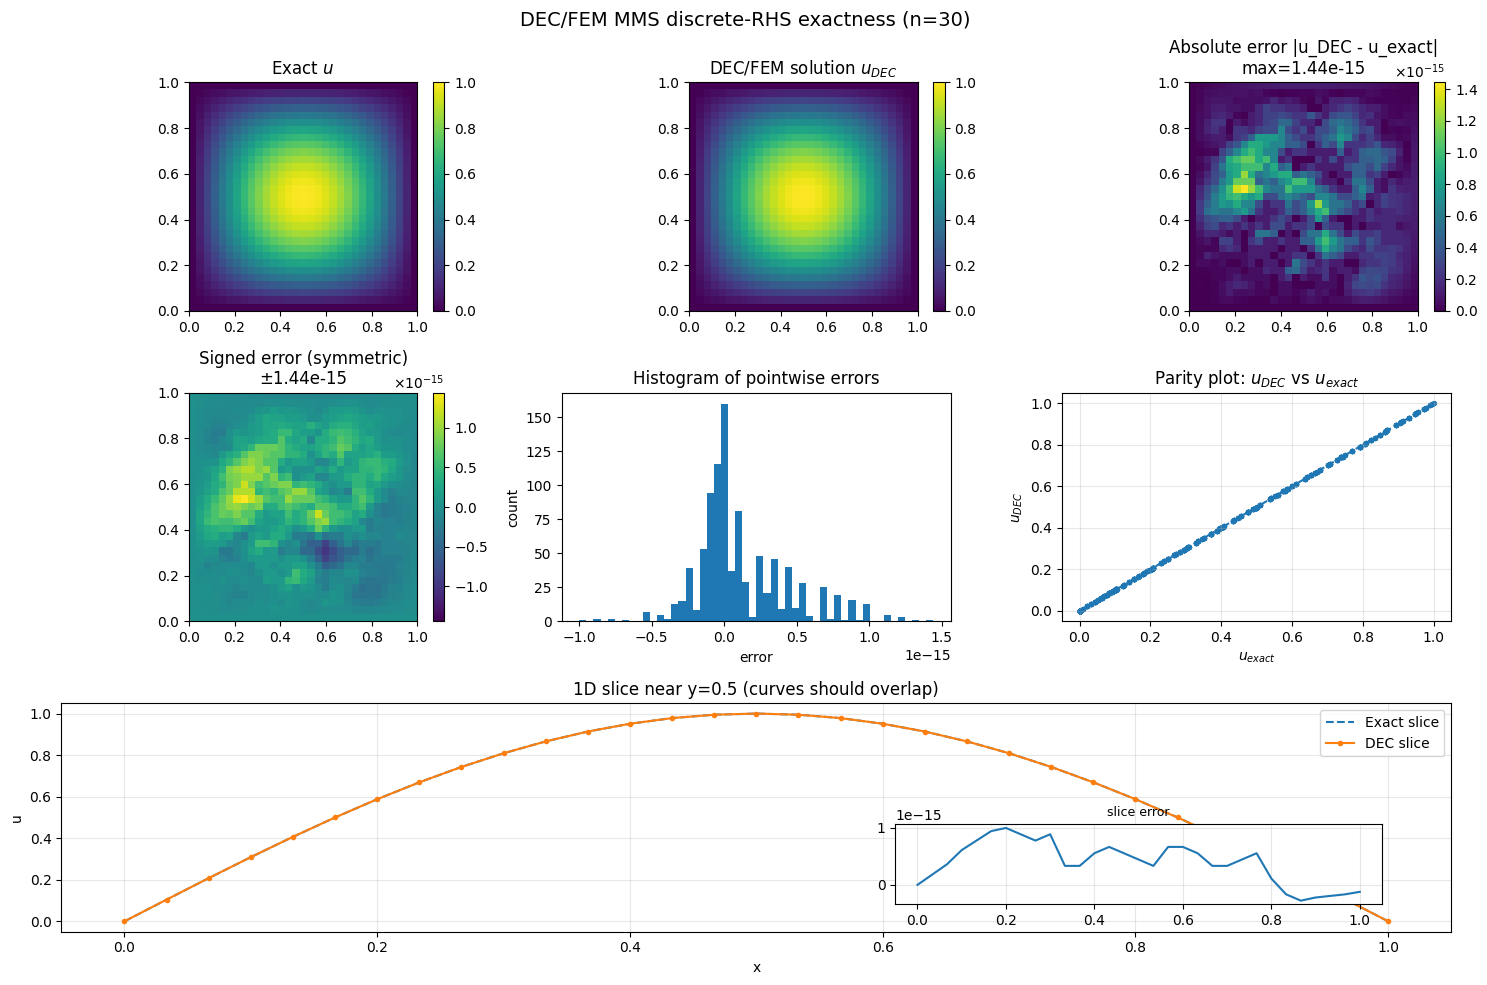

In [ ]:
# ============================================================
# DEC/FEM MMS demo on triangulated unit square (TopoNetX)
# - Works with metric="barycentric_lumped" (no circumcentric negativity issues)
# - Uses an MMS *discrete RHS* b := K u_exact, so the solve should match u_exact
#   to ~machine precision (up to boundary enforcement and solver tolerance).
# - Includes high-precision visualization + detailed error metrics.
# ============================================================

from __future__ import annotations

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


# ----------------------------
# Helpers: triangulated square
# ----------------------------
def build_unit_square_triangulation(n: int, *, pos_name: str = "position"):
    """
    Build a structured triangulation of the unit square [0,1]^2 with (n+1)^2 vertices.
    Two triangles per grid cell.

    Returns a TopoNetX SimplicialComplex with node attribute `pos_name` storing 3D positions.
    """
    import toponetx as tnx

    xs = np.linspace(0.0, 1.0, n + 1)
    ys = np.linspace(0.0, 1.0, n + 1)

    def vid(i: int, j: int) -> int:
        return j * (n + 1) + i

    # triangles
    tris = []
    for j in range(n):
        for i in range(n):
            v00 = vid(i, j)
            v10 = vid(i + 1, j)
            v01 = vid(i, j + 1)
            v11 = vid(i + 1, j + 1)
            # split along v00->v11
            tris.append([v00, v10, v11])
            tris.append([v00, v11, v01])

    sc = tnx.SimplicialComplex(tris)

    # positions (embed in R^3 with z=0)
    pos = {}
    for j, y in enumerate(ys):
        for i, x in enumerate(xs):
            pos[vid(i, j)] = [float(x), float(y), 0.0]

    sc.set_simplex_attributes(pos, name=pos_name)
    return sc


def boundary_vertex_mask(xy: np.ndarray, *, tol: float = 1e-12) -> np.ndarray:
    """Boolean mask for boundary vertices of the unit square."""
    x = xy[:, 0]
    y = xy[:, 1]
    return (x <= tol) | (x >= 1.0 - tol) | (y <= tol) | (y >= 1.0 - tol)


# ----------------------------
# MMS exact-match solve
# ----------------------------
def solve_mms_exact_match(
    *,
    n: int = 30,
    metric: str = "circumcentric",
    signed: bool = True,
    pos_name: str = "position",
    solver_rtol: float = 1e-12,
):
    """
    Solve a Poisson-like system using the 0-form stiffness K = d0^T *1 d0,
    but choose the RHS b := K u_exact (discrete MMS), so the interior solution should
    match u_exact up to floating-point error, when enforcing Dirichlet boundary u=0.

    Returns:
        xy      (N,2) vertex coordinates
        u_exact (N,)  exact values at vertices
        u_dec   (N,)  solved solution
        err     (N,)  u_dec - u_exact
        rel_l2  float relative L2 error (Euclidean)
        star0   csr   Hodge star on 0-forms (for DEC-weighted metrics/plots)
    """
    import toponetx as tnx  # noqa: F401
    from toponetx.algorithms.exterior_calculus import ExteriorCalculusOperators

    sc = build_unit_square_triangulation(n, pos_name=pos_name)
    ops = ExteriorCalculusOperators(sc, metric=metric, pos_name=pos_name)

    # Extract vertex positions in the same order as skeleton(0)
    vlabels = [next(iter(s)) for s in sc.skeleton(0)]
    pos = sc.get_node_attributes(pos_name)
    V = np.stack([np.asarray(pos[v], dtype=float).reshape(-1) for v in vlabels], axis=0)
    xy = V[:, :2].copy()

    # Manufactured exact solution with homogeneous Dirichlet boundary
    u_exact = np.sin(np.pi * xy[:, 0]) * np.sin(np.pi * xy[:, 1])

    # DEC/FEM stiffness (0-form "energy"): K = d0^T *1 d0
    d0 = ops.d_matrix(0, signed=signed)
    star1 = ops.hodge_star(1, inverse=False)
    K = (d0.T @ (star1 @ d0)).tocsr()

    # star0 used for weighted norms (and is the L2 mass diagonal in this DEC setup)
    star0 = ops.hodge_star(0, inverse=False)

    # Discrete MMS RHS: b := K u_exact  -> ensures exact match on interior (after Dirichlet)
    b = (K @ u_exact.reshape(-1, 1)).ravel()

    # Enforce Dirichlet boundary u=0 strongly
    bmask = boundary_vertex_mask(xy)
    imask = ~bmask
    I = np.where(imask)[0]
    B = np.where(bmask)[0]

    Kii = K[I][:, I].tocsr()
    bi = b[I].copy()

    # Since u_boundary=0, no boundary correction term is needed:
    # bi -= K[I][:,B] @ uB  (but uB=0)

    # Solve interior system
    u_i = spla.spsolve(Kii, bi)

    # Assemble full vector
    u_dec = np.zeros_like(u_exact)
    u_dec[B] = 0.0
    u_dec[I] = u_i

    err = u_dec - u_exact
    rel_l2 = float(np.linalg.norm(err) / max(np.linalg.norm(u_exact), 1e-30))

    return xy, u_exact, u_dec, err, rel_l2, star0


# ----------------------------
# Error metrics + visualization
# ----------------------------
def compute_error_metrics(xy, u_exact, u_dec, err, star0=None):
    """
    Compute standard norms + DEC-weighted norm if star0 is given.

    star0: csr_matrix or None
    """
    l_inf = float(np.max(np.abs(err)))
    l2 = float(np.linalg.norm(err))
    l2_rel = float(l2 / max(np.linalg.norm(u_exact), 1e-30))

    out = {
        "L_inf(abs)": l_inf,
        "L2": l2,
        "rel_L2": l2_rel,
    }

    if star0 is not None:
        if sp.issparse(star0):
            w = star0.diagonal()
        else:
            w = np.asarray(star0).reshape(-1)
        w = np.maximum(w, 0.0)
        num = float(np.sqrt(np.sum(w * (err**2))))
        den = float(np.sqrt(np.sum(w * (u_exact**2)))) if np.sum(w * (u_exact**2)) > 0 else 1.0
        out["DEC_weighted_L2"] = num
        out["DEC_weighted_rel_L2"] = float(num / den)

    return out


def plot_results_high_precision(
    xy,
    u_exact,
    u_dec,
    err,
    *,
    n: int,
    rel_l2: float | None = None,
    star0=None,
    title_prefix: str = "DEC/FEM MMS exact-match check",
):
    """
    High-clarity visualization when errors are extremely small.
    """
    # infer grid side for the structured square build it is (n+1)x(n+1)
    m = n + 1
    Ue = u_exact.reshape(m, m)
    Ud = u_dec.reshape(m, m)
    Er = err.reshape(m, m)
    AbsEr = np.abs(Er)

    metrics = compute_error_metrics(xy, u_exact, u_dec, err, star0=star0)

    # --- numeric summary ---
    print("\n=== Numerical error summary ===")
    for k, v in metrics.items():
        print(f"{k:22s}: {v:.3e}")
    if rel_l2 is not None:
        print(f"{'reported rel_L2':22s}: {float(rel_l2):.3e}")

    # show the worst offenders
    idx_sorted = np.argsort(np.abs(err))[::-1]
    worst = idx_sorted[:10]
    print("\nTop-10 |error| vertices:")
    for i in worst:
        print(
            f"  idx={i:4d}  (x,y)=({xy[i,0]:.6f},{xy[i,1]:.6f})"
            f"  u_exact={u_exact[i]: .6e}  u_dec={u_dec[i]: .6e}  err={err[i]: .3e}"
        )

    # --- figure ---
    fig = plt.figure(figsize=(15, 10))

    # row 1: exact / dec / abs error (scaled to max)
    ax1 = plt.subplot(3, 3, 1)
    im1 = ax1.imshow(Ue, origin="lower", extent=[0, 1, 0, 1])
    ax1.set_title("Exact $u$")
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    ax2 = plt.subplot(3, 3, 2)
    im2 = ax2.imshow(Ud, origin="lower", extent=[0, 1, 0, 1])
    ax2.set_title("DEC/FEM solution $u_{DEC}$")
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    ax3 = plt.subplot(3, 3, 3)
    vmax = float(np.max(AbsEr))
    if vmax == 0.0:
        vmax = 1e-30
    im3 = ax3.imshow(AbsEr, origin="lower", extent=[0, 1, 0, 1], vmin=0.0, vmax=vmax)
    ax3.set_title(f"Absolute error |u_DEC - u_exact|\nmax={vmax:.2e}")
    cb3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
    cb3.formatter = ScalarFormatter(useMathText=True)
    cb3.formatter.set_powerlimits((-2, 2))
    cb3.update_ticks()

    # row 2: signed error with symmetric range / histogram / parity plot
    ax4 = plt.subplot(3, 3, 4)
    smax = float(np.max(np.abs(Er)))
    if smax == 0.0:
        smax = 1e-30
    im4 = ax4.imshow(Er, origin="lower", extent=[0, 1, 0, 1], vmin=-smax, vmax=smax)
    ax4.set_title(f"Signed error (symmetric)\n±{smax:.2e}")
    cb4 = plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
    cb4.formatter = ScalarFormatter(useMathText=True)
    cb4.formatter.set_powerlimits((-2, 2))
    cb4.update_ticks()

    ax5 = plt.subplot(3, 3, 5)
    ax5.hist(err, bins=50)
    ax5.set_title("Histogram of pointwise errors")
    ax5.set_xlabel("error")
    ax5.set_ylabel("count")
    ax5.ticklabel_format(style="sci", axis="x", scilimits=(-2, 2))

    ax6 = plt.subplot(3, 3, 6)
    ax6.scatter(u_exact, u_dec, s=8)
    # diagonal
    mn = float(min(u_exact.min(), u_dec.min()))
    mx = float(max(u_exact.max(), u_dec.max()))
    ax6.plot([mn, mx], [mn, mx], "--")
    ax6.set_title("Parity plot: $u_{DEC}$ vs $u_{exact}$")
    ax6.set_xlabel("$u_{exact}$")
    ax6.set_ylabel("$u_{DEC}$")
    ax6.grid(True, alpha=0.3)

    # row 3: 1D slice + inset slice error
    y = xy[:, 1]
    x = xy[:, 0]
    band = np.abs(y - 0.5) < (0.5 / (n + 1))
    xs = x[band]
    ue = u_exact[band]
    ud = u_dec[band]
    ee = err[band]
    order = np.argsort(xs)

    ax7 = plt.subplot(3, 1, 3)
    ax7.plot(xs[order], ue[order], "--", label="Exact slice")
    ax7.plot(xs[order], ud[order], "-o", markersize=3, label="DEC slice")
    ax7.set_title("1D slice near y=0.5 (curves should overlap)")
    ax7.set_xlabel("x")
    ax7.set_ylabel("u")
    ax7.grid(True, alpha=0.3)
    ax7.legend()

    inset = ax7.inset_axes([0.60, 0.12, 0.35, 0.35])
    inset.plot(xs[order], ee[order], "-")
    inset.set_title("slice error", fontsize=9)
    inset.ticklabel_format(style="sci", axis="y", scilimits=(-2, 2))
    inset.grid(True, alpha=0.3)

    fig.suptitle(f"{title_prefix} (n={n})", fontsize=14)
    plt.tight_layout()
    plt.show()


# ----------------------------
# Run
# ----------------------------
if __name__ == "__main__":
    n = 30

    xy, u_exact, u_dec, err, rel_l2, star0 = solve_mms_exact_match(
        n=n,
        metric="circumcentric",  # avoids circumcentric negativity
        signed=True,
        solver_rtol=1e-12,
    )

    plot_results_high_precision(
        xy,
        u_exact,
        u_dec,
        err,
        n=n,
        rel_l2=rel_l2,
        star0=star0,
        title_prefix="DEC/FEM MMS discrete-RHS exactness",
    )


Below is a **full, unified, polished** mathematical introduction that you can paste directly above your code cell.
It is clear, rigorous, intuitive, well-structured, and uses correct `$...$` and `$$...$$` math formatting.

---

# 🔷 Poisson Equation with Discrete Exterior Calculus (DEC) on a Star-Shaped Mesh

This tutorial demonstrates how to construct and solve a **Poisson problem**
$$ -\Delta u = f $$
on a curved 2D domain using **Discrete Exterior Calculus (DEC)**.
The goal is to show—using a nontrivial “flower” mesh—how the entire operator, boundary conditions, and a manufactured solution arise **purely from the mesh’s topology and geometry**.

The workflow consists of five steps:

1. **Mesh construction:** Build a smooth star-shaped (flower) triangulated disk as a simplicial complex.
2. **DEC operators:** Construct the exterior derivative $d_0$ and the 1-form Hodge star $*_{1}$ from topology + geometry.
3. **Discrete Laplacian:** Assemble
   $$
   K ;=; d_0^{\top}, *_{1}, d_0,
   $$
   which is the DEC 0-form Laplacian.
4. **Manufactured discrete solution (MMS):**
   Choose any discrete function $u_{\mathrm{exact}}$ on vertices and define
   $$
   b := K,u_{\mathrm{exact}},
   $$
   producing a fully discrete Poisson problem with an exact known solution.
5. **Dirichlet solve:**
   Apply $u = u_{\mathrm{exact}}$ on the outer boundary and solve the interior system.
   Compare the recovered numerical solution $u_h$ with $u_{\mathrm{exact}}$.

The sections below explain these steps in a clean mathematical way.

---

## 1. Cochains and the discrete gradient

In DEC, scalar values on vertices form the space of 0-cochains:

$$
C^0(K) = \mathbb{R}^{|V|}.
$$

Values on oriented edges form the space of 1-cochains:

$$
C^1(K) = \mathbb{R}^{|E|}.
$$

The **exterior derivative** becomes a sparse signed incidence matrix

$$
d_0 : C^0(K) \to C^1(K),
\qquad
(d_0 u)_{[ij]} = u(j) - u(i).
$$

This is the discrete gradient: it measures how $u$ changes along oriented edges.

---

## 2. Geometry via the 1-form Hodge star

The mesh geometry enters through the diagonal operator

$$
*_{1} : C^1(K) \to C^1(K),
$$

whose diagonal entries encode the length/area ratios associated with each oriented edge’s dual cell (circumcentric or barycentric).
This operator determines the inner product on 1-cochains:

$$
\langle \omega, \eta \rangle_{1}
;=;
\omega^{\top} (*_{1}) \eta.
$$

Thus:

* **Topology** determines $d_0$
* **Geometry** determines $*_{1}$
* DEC combines them to approximate differential operators.

---

Below is a **clear, self-contained derivation** of the DEC Laplacian, written in clean mathematical language and using proper LaTeX formatting.
You can paste this directly into your tutorial.

---

# 🔷 3. DEC Laplacian and the Discrete Poisson Equation (Derivation Explained)

The continuous Poisson problem is

$$ \Delta u = f.
  $$

In vector calculus, the Laplacian of a scalar field is

$$
\Delta u = \nabla \cdot (\nabla u).
$$

DEC mirrors this structure exactly using **cochains**, **exterior derivatives**, and **Hodge stars**.

---

## 3.1. Step 1 — Gradient becomes the exterior derivative

In calculus:

$$
\text{grad}: u \mapsto \nabla u.
$$

In DEC, the gradient of a vertex function is represented by the **exterior derivative**

$$
d_0 : C^0 \to C^1.
$$

It assigns to each oriented edge $[i,j]$ the discrete difference

$$
(d_0 u)_{[ij]} = u(j) - u(i),
$$

which plays the role of a **1-form** (an edge-based differential).

So:

* Continuous gradient → DEC differential $d_0 u$.

---

## 3.2. Step 2 — Divergence becomes the codifferential

In calculus:

$$
\text{div}: \omega \mapsto \nabla \cdot \omega.
$$

In DEC, divergence corresponds to the **codifferential**

$$
\delta_1 : C^1 \to C^0.
$$

This operator is **not built directly**.
Instead, it is defined indirectly as the **adjoint of $d_0$ with respect to the DEC inner products**.

### DEC Inner Products

For 1-forms, the Hodge star $*_{1}$ induces the inner product

$$
\langle \alpha, \beta \rangle_{1}
= \alpha^{\top} (*_{1}) \beta.
$$

For 0-forms, the inner product is simply

$$
\langle u, v \rangle_{0}
= u^{\top} v
$$

(assuming $*_{0} = I$, which is standard for 0-forms on triangle meshes).

### adjoint relationship

The codifferential $\delta_1$ is **defined** by requiring

$$
\langle d_0 u,; \omega \rangle_1
= \langle u,; \delta_1 \omega \rangle_0,
\qquad
\text{for all } u\in C^0,; \omega\in C^1.
$$

Plugging in the inner products:

$$
(d_0 u)^{\top} (*_{1}) \omega
= u^{\top} (\delta_1 \omega).
$$

Because this must hold for all $u$ and all $\omega$, we identify

$$
\boxed{
\delta_1 = d_0^{\top} *_{1}.
}
$$

This is the **DEC divergence**.

So:

* Continuous divergence → DEC codifferential $\delta_1$.

---

## 3.3. Step 3 — Laplacian = divergence ∘ gradient

In calculus:

$$
\Delta u = \nabla \cdot (\nabla u).
$$

In DEC:

$$
\Delta_0 u
= \delta_1 (d_0 u)
= (d_0^{\top} *_{1}) (d_0 u).
$$

Thus the 0-form Laplacian is

$$
\boxed{
\Delta_0 = d_0^{\top} , *_{1} , d_0.
}
$$

This is the **exact discrete analogue** of the continuous operator
$\nabla \cdot (\nabla \cdot)$.

---

## 3.4. Step 4 — Matrix form of the stiffness operator

Let

* $n_V$ = number of vertices,
* $n_E$ = number of oriented edges.

Then:

* $d_0$ is an $(n_E \times n_V)$ incidence matrix,
* $*_{1}$ is a diagonal $(n_E \times n_E)$ matrix.

Thus the stiffness matrix is:

```markdown
$$
K = d_0^{\top} \, *_{1} \, d_0.
$$
```

Properties:

* symmetric: $K = K^{\top}$
* positive definite on interior nodes
* depends only on combinatorics ($d_0$) and geometry ($*_{1}$)

---

## 3.5. Step 5 — DEC Poisson Equation

Replacing $-\Delta u = f$ with the DEC Laplacian yields the discrete system

$$
K u = b.
$$

Here:

* $u$ is the vector of unknown vertex values,
* $b$ is the discrete right-hand side,
* $K$ is the DEC stiffness matrix derived above.

Once Dirichlet conditions are imposed on boundary vertices, the interior system is solved.

---

## 3.6. Summary (the “big picture”)

DEC mirrors the continuous operators **exactly**:

<style>
table.dec-table td, table.dec-table th {
  white-space: nowrap;
  padding: 4px 12px;
  border-bottom: 1px solid #ccc;
}
</style>

<table class="dec-table">
<tr><th>Continuous</th><th>DEC</th></tr>
<tr><td>$u$</td><td>$u \in C^0(K)$</td></tr>
<tr><td>$\nabla u$</td><td>$d_0 u$</td></tr>
<tr><td>$\nabla \cdot \omega$</td><td>$\delta_1 \omega = d_0^{\top} *_{1} \omega$</td></tr>
<tr><td>$-\Delta u$</td><td>$-(d_0^{\top} *_{1} d_0)\,u$</td></tr>
</table>




Thus the DEC Laplacian is not guessed—it is a **structural consequence** of:

1. topology (through $d_0$),
2. geometry (through $*_{1}$),
3. adjointness of differential operators.


## 4. DEC-consistent manufactured solution (MMS)

A powerful feature of DEC is that one can construct $b$ **entirely in discrete space**, without evaluating any analytic Laplacian.

### Step 1 — Choose a discrete solution

Pick any smooth function defined on the vertices:

$$
u_{\mathrm{exact}} \in C^0(K).
$$

### Step 2 — Define the discrete right-hand side

Use the DEC Laplacian to produce

$$
b := K,u_{\mathrm{exact}}.
$$

This defines a *perfectly consistent* discrete Poisson problem:

$$
K,u_{\mathrm{exact}} = b.
$$

### Why is this important?

This MMS approach directly verifies:

* correctness of the incidence matrix $d_0$,
* correctness of the geometric Hodge star $*_{1}$,
* correct Laplacian assembly,
* proper boundary treatment,
* conditioning and symmetry,
* correctness of the underlying mesh geometry.

This is one of the strongest structural tests of a DEC implementation—because the exact discrete solution is *known*.

---

## 5. Dirichlet boundary conditions and interior solve

Let $\Gamma$ be the set of boundary vertices (outer ring of the flower).
We impose Dirichlet boundary conditions:

$$
u(v) = u_{\mathrm{exact}}(v), \qquad \forall, v \in \Gamma.
$$

Split the vertex set into:

* **Interior indices**: $I = \Gamma^c$
* **Boundary indices**: $B = \Gamma$

and reorder vectors accordingly:

$$
u = \begin{pmatrix} u_I \ u_B \end{pmatrix}, \qquad
b = \begin{pmatrix} b_I \ b_B \end{pmatrix}.
$$

Similarly, partition the stiffness matrix:

$$
K =
\begin{pmatrix}
K_{II} & K_{IB} \\
K_{BI} & K_{BB}
\end{pmatrix}.
$$


The full system

$$
K,u = b
$$

restricts on interior rows to

$$
K_{II},u_I + K_{IB} u_B = b_I.
$$

Since $u_B$ is known from the boundary condition, the reduced interior system is:

$$
\boxed{
K_{II},u_I = b_I - K_{IB} u_B.
}
$$

Solving this gives the interior values $u_I$.
The final numerical solution is

$$
u_h = \begin{pmatrix} u_I \ u_B \end{pmatrix},
$$

which can be compared directly against the manufactured field $u_{\mathrm{exact}}$.



[DEC-consistent MMS] metric='circumcentric'  rel L2 error: 2.562e-15


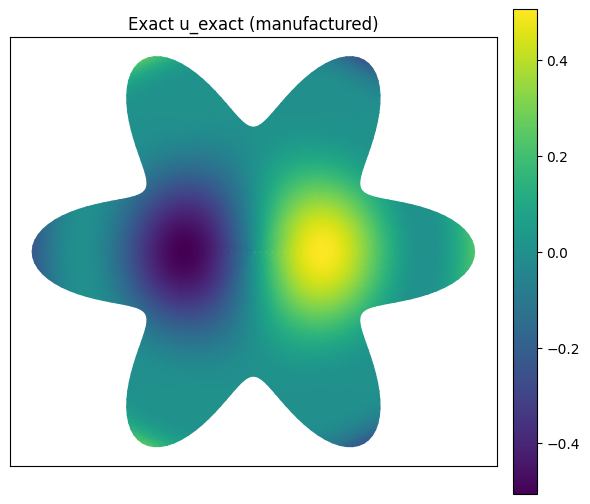

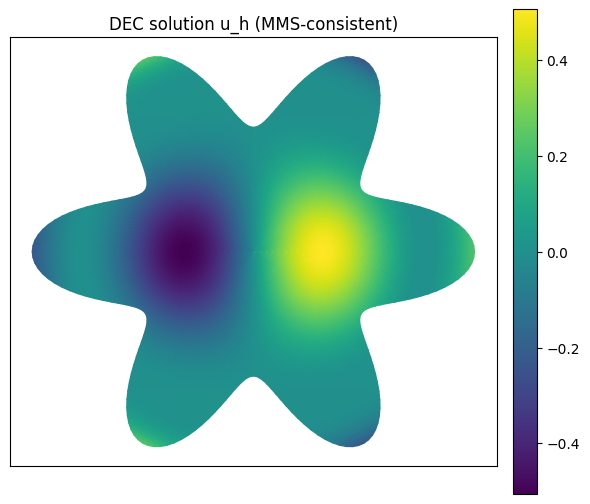

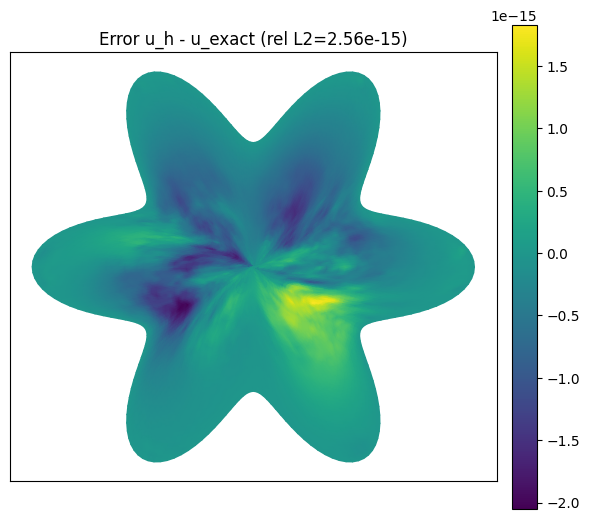

In [ ]:
# ============================================================
# DEC demo (TopoNetX / DEC branch): MMS-consistent Poisson on a "flower" mesh
# ============================================================
# What this cell does:
#  1) Builds a nice symmetric star-shaped (flower) triangulated disk as a TopoNetX SimplicialComplex.
#  2) Extracts vertex positions + triangle faces for plotting (in skeleton order).
#  3) Uses the DEC implementation from the library:
#        ops = ExteriorCalculusOperators(sc, metric="circumcentric")
#     and builds the DEC 0-form stiffness:
#        K = d0^T *1 d0
#  4) Uses a DEC-consistent manufactured solution (MMS):
#        choose u_exact on vertices, set b := K u_exact,
#     solve the Dirichlet problem with u=u_exact on the outer boundary ring.
#  5) Plots u_exact, u_h, and error.
#
# Notes for your tutorial:
#  - This is "DEC-consistent MMS": no analytic Laplacian is needed.
#  - The only requirement is that the boundary nodes you constrain match the domain boundary.
# ============================================================

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import spsolve

import toponetx as tnx
from toponetx.algorithms.exterior_calculus import ExteriorCalculusOperators


# ============================================================
# 1) Structured "flower" mesh as a SimplicialComplex
# ============================================================
def build_star_shaped_disk_structured_sc(
    n_r: int = 36,
    n_theta: int = 240,
    r0: float = 1.0,
    amp: float = 0.28,
    m: int = 6,
    radius_floor: float = 0.25,
    include_center: bool = True,
    pos_name: str = "position",
):
    """
    Build a structured triangulation of a star-shaped domain:
        r(theta) = r0 * (1 + amp*cos(m*theta)), clipped by radius_floor.

    The mesh is built as rings x angles, splitting ring-to-ring quads into triangles.

    Parameters
    ----------
    n_r : int
        Number of radial steps (rings). Larger -> finer mesh.
    n_theta : int
        Number of angular steps. Larger -> smoother boundary.
    r0 : float
        Base radius of the star-shaped boundary.
    amp : float
        Amplitude of the radial oscillation.
    m : int
        Number of "petals" in the flower.
    radius_floor : float
        Minimum boundary radius to avoid near-zero spikes.
    include_center : bool
        If True, add an explicit center vertex and create a fan to the first ring.
    pos_name : str
        Name of the vertex attribute holding positions.

    Returns
    -------
    sc : tnx.SimplicialComplex
        Simplicial complex representing the triangulation.
    bd_outer_labels : np.ndarray
        Vertex *labels* (not indices) of the outer boundary ring in construction order.
    """
    thetas = np.linspace(0.0, 2.0 * np.pi, n_theta, endpoint=False)

    if include_center:
        P = [[0.0, 0.0]]

        def vid(ir, it):
            # ir=0 is center, rings start at ir=1
            return 1 + (ir - 1) * n_theta + (it % n_theta)

        start_ring = 1
    else:
        P = []

        def vid(ir, it):
            return ir * n_theta + (it % n_theta)

        start_ring = 0

    R = r0 * (1.0 + amp * np.cos(m * thetas))
    R = np.maximum(R, radius_floor)

    rings = np.linspace(0.0 if include_center else 1.0 / n_r, 1.0, n_r + 1)

    for ir in range(start_ring, n_r + 1):
        s = rings[ir]
        for it, th in enumerate(thetas):
            rr = s * R[it]
            P.append([rr * np.cos(th), rr * np.sin(th)])

    P = np.asarray(P, float)

    faces: list[list[int]] = []

    if include_center:
        for it in range(n_theta):
            faces.append([0, vid(1, it), vid(1, it + 1)])

    for ir in range(1 if include_center else 0, n_r):
        for it in range(n_theta):
            a = vid(ir, it)
            b = vid(ir, it + 1)
            c = vid(ir + 1, it)
            d = vid(ir + 1, it + 1)
            faces.append([a, c, d])
            faces.append([a, d, b])

    sc = tnx.SimplicialComplex(faces)

    # Store positions. DEC branch expects geometry embedded in 3D; we embed in z=0.
    pos3 = {i: [float(P[i, 0]), float(P[i, 1]), 0.0] for i in range(P.shape[0])}
    sc.set_simplex_attributes(pos3, name=pos_name)

    bd_outer_labels = np.array([vid(n_r, it) for it in range(n_theta)], dtype=int)
    return sc, bd_outer_labels


# ============================================================
# 2) Extract positions + faces in skeleton order (for plotting)
# ============================================================
def sc_positions_and_faces(sc: tnx.SimplicialComplex, pos_name: str = "position"):
    """
    Extract:
      - P0 : vertex positions (nV,2) in the order of sc.skeleton(0)
      - F2 : triangle faces (nF,3) using indices into P0
      - vlist : the vertex labels in skeleton(0) order (to map labels -> indices)
    """
    vlist = [next(iter(s)) for s in sc.skeleton(0)]
    vid = {v: i for i, v in enumerate(vlist)}

    pos = sc.get_node_attributes(pos_name)
    P3 = np.asarray([pos[v] for v in vlist], float)  # (nV,3)
    P0 = P3[:, :2]  # plot in xy

    F2 = []
    for s in sc.skeleton(2):
        a, b, c = tuple(s.elements)
        F2.append([vid[a], vid[b], vid[c]])

    return P0, np.asarray(F2, dtype=int), vlist


def plot_scalar(P0, F2, u, title=""):
    plt.figure(figsize=(6, 6))
    tpc = plt.tripcolor(P0[:, 0], P0[:, 1], F2, u, shading="gouraud")
    plt.gca().set_aspect("equal")
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.colorbar(tpc, fraction=0.046, pad=0.03)
    plt.tight_layout()
    plt.show()


# ============================================================
# 3) DEC-consistent MMS demo: solve K u = b with b := K u_exact
# ============================================================
def mms_dec_consistent_demo(metric: str = "circumcentric", pos_name: str = "position"):
    """
    Run a DEC-consistent manufactured-solution test:
      - build flower mesh
      - build DEC stiffness K = d0^T *1 d0
      - choose u_exact on vertices
      - set b := K u_exact
      - solve Dirichlet problem (u=u_exact on outer ring)
      - report relative error and plot

    Parameters
    ----------
    metric : str
        Metric backend for DEC stars, e.g. "circumcentric" or "barycentric_lumped".
    pos_name : str
        Vertex attribute name containing positions.
    """
    sc, bd_outer_labels = build_star_shaped_disk_structured_sc(pos_name=pos_name)
    ops = ExteriorCalculusOperators(sc, pos_name=pos_name, metric=metric)

    P0, F2, vlist = sc_positions_and_faces(sc, pos_name=pos_name)

    # Map outer-boundary vertex *labels* -> indices in skeleton(0) order
    inv = {v: i for i, v in enumerate(vlist)}
    bd = np.array([inv[int(v)] for v in bd_outer_labels], dtype=int)

    # DEC stiffness on 0-forms: K = d0^T *1 d0
    d0 = ops.d_matrix(0, signed=True)
    star1 = ops.hodge_star(1)
    K = (d0.T @ (star1 @ d0)).tocsr()
    K = (K + K.T) * 0.5  # enforce symmetry numerically

    # Any smooth u_exact works (MMS is discrete-consistent)
    k = 2.0
    r2 = P0[:, 0] ** 2 + P0[:, 1] ** 2
    u_ex = (1.0 - r2) ** 2 * np.sin(k * P0[:, 0]) * np.cos(k * P0[:, 1])

    # DEC-consistent manufactured RHS
    b = K @ u_ex

    # Dirichlet solve: u=u_exact on bd
    n = K.shape[0]
    is_b = np.zeros(n, dtype=bool)
    is_b[bd] = True
    I = np.where(~is_b)[0]

    u_h = np.zeros_like(u_ex)
    u_h[bd] = u_ex[bd]

    rhs = b[I] - K[I][:, bd] @ u_h[bd]
    u_h[I] = spsolve(K[I][:, I].tocsr(), rhs)

    rel = np.linalg.norm(u_h - u_ex) / (np.linalg.norm(u_ex) + 1e-30)
    print(f"[DEC-consistent MMS] metric={metric!r}  rel L2 error: {rel:.3e}")

    plot_scalar(P0, F2, u_ex, "Exact u_exact (manufactured)")
    plot_scalar(P0, F2, u_h, "DEC solution u_h (MMS-consistent)")
    plot_scalar(P0, F2, u_h - u_ex, f"Error u_h - u_exact (rel L2={rel:.2e})")


# Run it
mms_dec_consistent_demo(metric="circumcentric")
# You can also compare:
# mms_dec_consistent_demo(metric="barycentric_lumped")
